In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from mwem import MWEMSynthesizer

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [74]:
#%%
import sys
import os
import math
import random
import warnings
import time

import numpy as np
import pandas as pd

from opendp.whitenoise.synthesizers.base import SDGYMBaseSynthesizer

class MWEMSynthesizer(SDGYMBaseSynthesizer):
    """
    N-Dimensional numpy implementation of MWEM. 
    (http://users.cms.caltech.edu/~katrina/papers/mwem-nips.pdf)

    From the paper:
    "[MWEM is] a broadly applicable, simple, and easy-to-implement algorithm, capable of
    substantially improving the performance of linear queries on many realistic datasets...
    (circa 2012)...MWEM matches the best known and nearly
    optimal theoretical accuracy guarantees for differentially private 
    data analysis with linear queries."

    Linear queries used for sampling in this implementation are
    random contiguous slices of the n-dimensional numpy array. 
    """
    def __init__(self, Q_count=400, epsilon=3.0, iterations=30, mult_weights_iterations=20, splits = [], split_factor=None, max_bin_count=500):
        self.Q_count = Q_count
        self.epsilon = epsilon
        self.iterations = iterations
        self.mult_weights_iterations = mult_weights_iterations
        self.synthetic_data = None
        self.data_bins = None
        self.real_data = None
        self.splits = splits
        self.split_factor = split_factor
        self.max_bin_count = max_bin_count
        self.mins_maxes = {}
        self.scale = {}
        
    def fit(self, data):
        """
        Creates a synthetic histogram distribution, based on the original data.
        Follows sdgym schema to be compatible with their benchmark system.

        :param data: Dataset to use as basis for synthetic data
        :type data: np.ndarray
        :return: synthetic data, real data histograms
        :rtype: np.ndarray
        """
        if isinstance(data, np.ndarray):
            self.data = data.copy()
        else:
            raise ValueError("Data must be a numpy array.")

        if self.split_factor != None and self.splits == []:
            self.splits = self._generate_splits(data.T.shape[0], self.split_factor)

        self.splits = np.array(self.splits)
        if self.splits.size == 0:
            self.histograms = self._histogram_from_data_attributes(self.data, [np.arange(self.data.shape[1])])
        else:
            self.histograms = self._histogram_from_data_attributes(self.data, self.splits)
        
        self.Qs = []
        for h in self.histograms:
            # h[1] is dimensions for each histogram
            self.Qs.append(self._compose_arbitrary_slices(self.Q_count, h[1]))

        # Run the algorithm
        self.synthetic_histograms = self.mwem()

    def sample(self, samples):
        """
        Creates samples from the histogram data.
        Follows sdgym schema to be compatible with their benchmark system.

        :param samples: Number of samples to generate
        :type samples: int
        :return: N samples
        :rtype: list(np.ndarray)
        """
        synthesized_columns = ()
        first = True
        for fake, _ , split in self.synthetic_histograms:
            s = []
            fake_indices = np.arange(len(np.ravel(fake)))
            fake_distribution = np.ravel(fake)
            norm = np.sum(fake)

            for _ in range(samples):
                s.append(np.random.choice(fake_indices, p=(fake_distribution/norm)))

            s_unraveled = []
            for ind in s:
                s_unraveled.append(np.unravel_index(ind,fake.shape))
            
            # Here we make scale adjustments to match the original
            # data
            np_unraveled = np.array(s_unraveled)
            
            for i in range(np_unraveled.shape[-1]):
                min_c, max_c = self.mins_maxes[str(split[i])]
                # TODO: Deal with the 0 edge case when scaling
                # i.e. scale factor * 0th bin is 0, 
                # but should still scale appropriately
                np_unraveled[:,i] = np_unraveled[:,i] * self.scale[str(split[i])]
                np_unraveled[:,i] = np_unraveled[:,i] + min_c
            
            if first:
                synthesized_columns = np_unraveled
                first = False
            else:
                synthesized_columns = np.hstack((synthesized_columns, np_unraveled))
        
        # Recombine the independent distributions into a single dataset
        combined = synthesized_columns
        # Reorder the columns to mirror their original order
        r = self._reorder(self.splits)
        return combined[:,r]

    def mwem(self):
        """
        Runner for the mwem algorithm. 

        Initializes the synthetic histogram, and updates it
        for self.iterations using the exponential mechanism and
        multiplicative weights. Draws from the initialized query store
        for measurements.
        :return: A, self.histogram - A is the synthetic data histogram, self.histogram is original histo
        :rtype: np.ndarray, np.ndarray
        """
        As = []

        for i,h in enumerate(self.histograms):
            hist = h[0]
            dimensions = h[1]
            split = h[3]
            Q = self.Qs[i]
            A = self._initialize_A(hist, dimensions)
            measurements = {}
            first = True

            for i in range(self.iterations):
                if first:
                    print('Initializing iteration with columns ' + str(split))
                    start = time.time()

                qi = self._exponential_mechanism(hist, A, Q, (self.epsilon / (2*self.iterations)))

                # Make sure we get a different query to measure:
                while(qi in measurements):
                    qi = self._exponential_mechanism(hist, A, Q, (self.epsilon / (2*self.iterations)))

                # NOTE: Add laplace noise here with budget
                evals = self._evaluate(Q[qi], hist)
                lap = self._laplace((2*self.iterations)/(self.epsilon*len(dimensions)))
                measurements[qi] = evals + lap

                # Improve approximation with Multiplicative Weights
                A = self._multiplicative_weights(A, Q, measurements, hist, self.mult_weights_iterations)
                
                if first:
                    end = time.time()
                    # Lower bound time estimate on next synthetic histogram
                    # Introduces arbitrary time factor, to reduce expectations : )
                    arbitrary_time_factor = self.iterations % 10 # Seems to slow down proportionally every ~10 iterations
                    t = str(round((end-start) * self.iterations * arbitrary_time_factor,3))
                    print('Estimate duration till completion: ' + t + ' seconds (lower bound)')
                    first = False

            As.append((A,hist,split))

        return As
    
    def _initialize_A(self, histogram, dimensions):
        """
        Initializes a uniform distribution histogram from
        the given histogram with dimensions

        :param histogram: Reference histogram
        :type histogram: np.ndarray
        :param dimensions: Reference dimensions
        :type dimensions: np.ndarray
        :return: New histogram, uniformly distributed according to
        reference histogram
        :rtype: np.ndarray
        """

        # NOTE: Could actually use a distribution from real data with some budget,
        # as opposed to using this uniform dist (would take epsilon as argument,
        # and detract from it)
        n = np.sum(histogram)
        value = n/np.prod(dimensions)
        A = np.zeros_like(histogram)
        A += value
        return A

    def _histogram_from_data_attributes(self, data, splits=[]):
        """
        Create a histogram from given data

        :param data: Reference histogram
        :type data: np.ndarray
        :return: Histogram over given data, dimensions, 
        bins created (output of np.histogramdd)
        :rtype: np.ndarray, np.shape, np.ndarray
        """
        histograms = []
        for split in splits:
            split_data = data[:, split]
            mins_data = []
            maxs_data = []
            dims_sizes = []

            # Transpose for column wise iteration
            for i, column in enumerate(split_data.T):
                min_c = min(column) ; max_c = max(column) 
                mins_data.append(min_c)
                maxs_data.append(max_c)
                # Dimension size (number of bins)
                bin_count = max_c-min_c+1
                # Here we track the min and max for the column,
                # for sampling
                self.mins_maxes[str(split[i])] = (min_c, max_c)
                if bin_count > self.max_bin_count:
                    # Note the limitations of MWEM here, specifically in the case of continuous data.
                    warnings.warn('Bin count ' + str(bin_count) + ' in column: ' + str(split[i]) + \
                                  ' exceeds max_bin_count, defaulting to: ' + str(self.max_bin_count)+\
                                  '. Is this a continuous variable?', Warning)
                    bin_count = self.max_bin_count
                    # We track a scaling factor per column, for sampling
                    self.scale[str(split[i])] = (max_c-min_c+1)/self.max_bin_count
                else:
                    self.scale[str(split[i])] = 1
                dims_sizes.append(bin_count)
            
            # Produce an N,D dimensional histogram, where
            # we pre-specify the bin sizes to correspond with 
            # our ranges above
            histogram, bins = np.histogramdd(split_data, bins=dims_sizes)
            # Return histogram, dimensions
            histograms.append((histogram, dims_sizes, bins, split))

        return histograms
    
    def _exponential_mechanism(self, hist, A, Q, eps):
        """
        Refer to paper for in depth description of
        Exponential Mechanism.

        Parametrized with epsilon value epsilon/(2 * iterations)

        :param hist: Basis histogram
        :type hist: np.ndarray
        :param A: Synthetic histogram
        :type A: np.ndarray
        :param Q: Queries to draw from
        :type Q: list
        :param eps: Budget
        :type eps: float
        :return: # of errors
        :rtype: int
        """
        errors = [abs(self._evaluate(Q[i], hist)-self._evaluate(Q[i], A)) * (eps/2.0) for i in range(len(Q))]
        maxi = max(errors)
        errors = [math.exp(errors[i] - maxi) for i in range(len(errors))]
        r = random.random()
        e_s = np.sum(errors)
        c = 0
        for i in range(len(errors)):
            c += errors[i]
            if c > r * e_s:
                return i
        return len(errors) - 1
    
    def _multiplicative_weights(self, A, Q, m, hist, iterate):
        """
        Multiplicative weights update algorithm,
        used to boost the synthetic data accuracy given measurements m.

        Run for iterate times

        
        :param A: Synthetic histogram
        :type A: np.ndarray
        :param Q: Queries to draw from
        :type Q: list
        :param m: Measurements taken from real data for each qi query
        :type m: dict
        :param hist: Basis histogram
        :type hist: np.ndarray
        :param iterate: Number of iterations to run mult weights
        :type iterate: iterate
        :return: A
        :rtype: np.ndarray
        """
        sum_A = np.sum(A)

        for _ in range(iterate):
            for qi in m:
                error = m[qi] - self._evaluate(Q[qi], A)

                # Perform the weights update
                query_update = self._binary_replace_in_place_slice(np.zeros_like(A.copy()), Q[qi])
                
                # Apply the update
                A_multiplier = np.exp(query_update * error/(2.0 * sum_A))
                A_multiplier[A_multiplier == 0.0] = 1.0
                A = A * A_multiplier

                # Normalize again
                count_A = np.sum(A)
                A = A * (sum_A/count_A)
        return A

    def _compose_arbitrary_slices(self, num_s, dimensions):
        """
        Here, dimensions is the shape of the histogram
        We want to return a list of length num_s, containing
        random slice objects, given the dimensions

        These are our linear queries

        :param num_s: Number of queries (slices) to generate
        :type num_s: int
        :param dimensions: Dimensions of histogram to be sliced
        :type dimensions: np.shape
        :return: Collection of random np.s_ (linear queries) for
        a dataset with dimensions
        :rtype: list
        """
        slices_list = []
        # TODO: For analysis, generate a distribution of slice sizes,
        # by running the list of slices on a dimensional array
        # and plotting the bucket size
        slices_list = []
        for _ in range(num_s):
            inds = []
            for _,s in np.ndenumerate(dimensions):
                # Random linear sample, within dimensions
                a = np.random.randint(s)
                b = np.random.randint(s)

                l_b = min(a,b) ; u_b = max(a,b) + 1
                pre = []
                pre.append(l_b)
                pre.append(u_b)
                inds.append(pre)

            # Compose slices
            sl = []
            for ind in inds:
                sl.append(np.s_[ind[0]:ind[1]])

            slices_list.append(sl)
        return slices_list

    def _evaluate(self, a_slice, data):
        """
        Evaluate a count query i.e. an arbitrary slice

        :param a_slice: Random slice within bounds of flattened data length
        :type a_slice: np.s_
        :param data: Data to evaluate from (synthetic dset)
        :type data: np.ndarray
        :return: Count from data within slice
        :rtype: float
        """
        # We want to count the number of objects in an
        # arbitrary slice of our collection

        # We use np.s_[arbitrary slice] as our queries
        e = data.T[tuple(a_slice)]
        
        if isinstance(e, np.ndarray):
            return np.sum(e)
        else:
            return e

    def _binary_replace_in_place_slice(self, data, a_slice):
        """
        We want to create a binary copy of the data,
        so that we can easily perform our error multiplication
        in MW. Convenience function.

        :param data: Data
        :type data: np.ndarray
        :param a_slice: Slice
        :type a_slice: np.s_
        :return: Return data, where the range specified
        by a_slice is all 1s.
        :rtype: np.ndarray
        """
        view = data.copy()
        view.T[tuple(a_slice)] = 1.0
        return view
    
    def _reorder(self, splits):
        """
        Given an array of dimensionality splits (column indices)
        returns the corresponding reorder array (indices to return
        columns to original order)

        Example:
        original = [[1, 2, 3, 4, 5, 6],
        [ 6,  7,  8,  9, 10, 11]]
        
        splits = [[1,3,4],[0,2,5]]
        
        mod_data = [[2 4 5 1 3 6]
                [ 7  9 10  6  8 11]]
        
        reorder = [3 0 4 1 2 5]

        :param splits: 2d list with splits (column indices)
        :type splits: array of arrays
        :return: 2d list with splits (column indices)
        :rtype: array of arrays
        """
        flat = np.concatenate(np.asarray(splits)).ravel()
        reordered = np.zeros(len(flat))
        for i, ind in enumerate(flat):
            reordered[ind] = i
        return reordered.astype(int)

    def _generate_splits(self, n_dim, factor):
        """
        If user specifies, do the work and figure out how to divide the dimensions
        into even splits to speed up MWEM

        Last split will contain leftovers <= sizeof(factor)

        :param n_dim: Total # of dimensions
        :type n_dim: int
        :param factor: Desired size of the splits
        :type factor: int
        :return: Splits
        :rtype: np.array(np.array(),...)
        """
        # Columns indices
        indices = np.arange(n_dim)
        
        # Split intelligently
        fits = int((np.floor(len(indices) / factor)) * factor)
        even_inds = indices[:fits].reshape((int(len(indices)/factor), factor))
        s1 = even_inds.tolist()
        if indices[fits:].size > 0: # != np.array([])
            s1.append(indices[fits:])
        s2 = [np.array(l) for l in s1]
        return np.array(s2)

    def _laplace(self, sigma):
        """
        Laplace mechanism

        :param sigma: Laplace scale param sigma
        :type sigma: float
        :return: Random value from laplace distribution [-1,1]
        :rtype: float
        """
        return sigma * np.log(random.random()) * np.random.choice([-1, 1])


In [75]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
adult = pd.read_csv('adult_5000.csv')

categorical_columns = ['workclass',
                       'marital-status', 
                       'occupation', 
                       'relationship', 
                       'race',
                       'gender',
                       'native-country',
                       'income']

ordinal_columns = ['education']

encoders = {}
for column in adult.columns:
    if adult.dtypes[column] == np.object:
        encoders[column] = LabelEncoder()
        adult[column] = encoders[column].fit_transform(adult[column])
# df = pd.read_csv('cancer.csv')
nf = adult.to_numpy()

In [76]:
#synth = MWEMSynthesizer(300, 10.0, 30, 20, [[0,1],[2,3],[4,5],[6,7],[8,9]])
# Alternatively, have MWEM split factor for you, by specifiying prefered size
# synth = MWEMSynthesizer(200, 10.0, 30, 20, split_factor=3, max_bin_count=200)
synth = MWEMSynthesizer(400, 10.0, 30, 20, [[2],[10,12],[11,13],[0,1,3,4],[5,6,7,8,9,14]], max_bin_count=200)
synth.fit(nf)
# synth = MWEMSynthesizer(400, 10.0, 30, 20, split_factor=5, max_bin_count=20)
# synth.fit(nf)
# synth = MWEMSynthesizer(400, 10.0, 30, 20, [[2],[10],[11],[12],[13],[0,1],[3,4,5,6,7,8,9,14]], max_bin_count=20)
# synth.fit(nf)

<ipython-input-74-7768ef499b33>:238: Warning: Bin count 642153 in column: 2 exceeds max_bin_count, defaulting to: 200. Is this a continuous variable?
  warnings.warn('Bin count ' + str(bin_count) + ' in column: ' + str(split[i]) + \
<ipython-input-74-7768ef499b33>:238: Warning: Bin count 100000 in column: 10 exceeds max_bin_count, defaulting to: 200. Is this a continuous variable?
  warnings.warn('Bin count ' + str(bin_count) + ' in column: ' + str(split[i]) + \
<ipython-input-74-7768ef499b33>:238: Warning: Bin count 2445 in column: 11 exceeds max_bin_count, defaulting to: 200. Is this a continuous variable?
  warnings.warn('Bin count ' + str(bin_count) + ' in column: ' + str(split[i]) + \


Initializing iteration with columns [2]
Estimate duration till completion: 0.388 seconds (lower bound)
Initializing iteration with columns [10, 12]
Estimate duration till completion: 0.807 seconds (lower bound)
Initializing iteration with columns [11, 13]
Estimate duration till completion: 0.457 seconds (lower bound)
Initializing iteration with columns [0, 1, 3, 4]
Estimate duration till completion: 2.498 seconds (lower bound)
Initializing iteration with columns [5, 6, 7, 8, 9, 14]
Estimate duration till completion: 0.626 seconds (lower bound)


In [69]:
sample_size = 999
synthetic = synth.sample(int(sample_size))

In [49]:
synthetic[1]

array([    83,      1, 190478,      1,     11,      6,     10,      0,
            3,      0,    500,      0,     36,     27,      0])

In [50]:
synth_df = pd.DataFrame(synthetic, 
    index=adult.index,
    columns=adult.columns)

X = adult.iloc[:, :-1]
y = adult.iloc[:, -1]
X_synth = synth_df.iloc[:, :-1]
y_synth = synth_df.iloc[:, -1]

In [51]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
x_train_synth, x_test_synth, y_train_synth, y_test_synth = train_test_split(X_synth, y_synth, test_size=0.1, random_state=42)

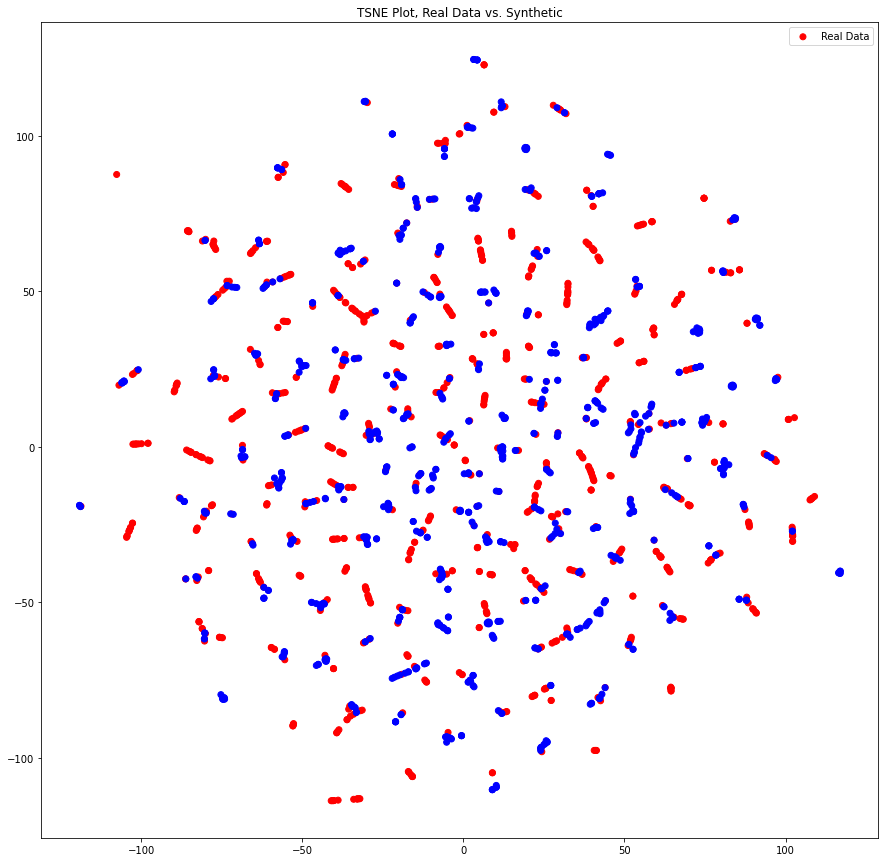

In [52]:
comb = np.vstack((x_train, x_train_synth))
embedding_1 = TSNE(n_components=2, perplexity=5.0, early_exaggeration=1.0).fit_transform(comb)
x,y = embedding_1.T
l = int(len(x) / 2)
inds = []

plt.rcParams["figure.figsize"] = (15,15)
plt.scatter(x,y,c=['purple' if i in inds else 'red' for i in range(l)]+['purple' if j in inds else 'blue' for j in range(l)])
plt.gca().legend(('Real Data','Real'))
plt.title('TSNE Plot, Real Data vs. Synthetic')
plt.show()

In [53]:
#Train the models
model_real = LogisticRegression()
model_real.fit(x_train, y_train)

model_fake = LogisticRegression()
model_fake.fit(x_train_synth, y_train_synth)

/home/lurosenb/anaconda3/envs/oss_dp_2/lib/python3.8/site-packages/sklearn/linear_model/logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "
/home/lurosenb/anaconda3/envs/oss_dp_2/lib/python3.8/site-packages/sklearn/linear_model/logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
#Test the model
predictions = model_real.predict(x_test)
print(predictions)
print()
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

              precision    recall  f1-score   support

           0       0.78      0.99      0.87        70
           1       0.92      0.37      0.52        30

    accuracy                           0.80       100
   macro avg       0.85      0.68      0.70       100
weighted avg       0.82      0.80      0.77       100

0.8


In [56]:
#Test the model
predictions = model_fake.predict(x_test_synth)
print(predictions)
print()
print(classification_report(y_test_synth, predictions))
print(accuracy_score(y_test_synth, predictions))

[1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1
 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1]

              precision    recall  f1-score   support

           0       0.50      0.31      0.38        55
           1       0.42      0.62      0.50        45

    accuracy                           0.45       100
   macro avg       0.46      0.47      0.44       100
weighted avg       0.47      0.45      0.44       100

0.45


In [162]:
df = pd.read_csv('fake_data_2d.csv')
nf = df.to_numpy()

synth = MWEMSynthesizer(400, 10.0, 30, 20,[[0,1]])
synth.fit(nf)
print('FAKE')
print(synth.synthetic_histograms[0][0])
print('REAL')
print(synth.synthetic_histograms[0][1])

FAKE
[[1.10951605 1.10951605 1.10951605 ... 0.9392413  1.10951605 1.10951605]
 [1.10951605 1.10951605 1.10951605 ... 0.9392413  1.10951605 1.10951605]
 [1.10951605 1.10951605 1.10951605 ... 0.9392413  1.10951605 1.10951605]
 ...
 [1.10951605 0.88133016 0.88133016 ... 1.10951605 1.10951605 1.10951605]
 [1.10951605 0.88133016 0.88133016 ... 1.10951605 1.10951605 1.10951605]
 [1.10951605 0.88133016 0.88133016 ... 1.10951605 1.10951605 1.10951605]]
REAL
[[1. 1. 3. ... 0. 0. 0.]
 [1. 1. 1. ... 2. 0. 1.]
 [1. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 6. 2. 3.]
 [1. 0. 0. ... 5. 6. 5.]
 [1. 0. 1. ... 1. 5. 5.]]


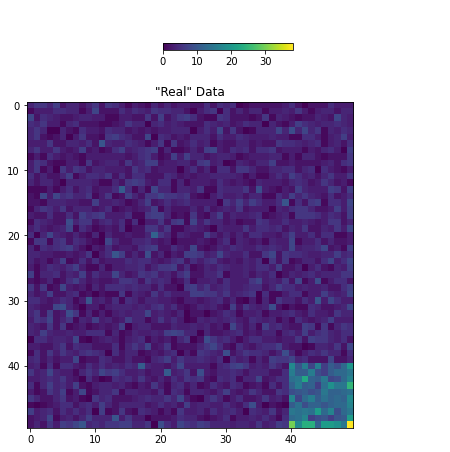

In [161]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_title('"Real" Data')
plt.imshow(synth.synthetic_histograms[0][1])
ax.set_aspect('equal')
cax = fig.add_axes([0.1, 1.0, 1., 0.1])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal')
plt.show()

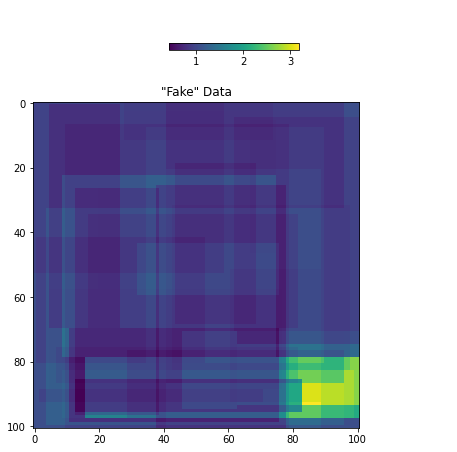

In [40]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.set_title('"Fake" Data')
plt.imshow(synth.synthetic_histograms[0][0])
cax = fig.add_axes([0.1, 1.0, 1., 0.1])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal')
plt.show()

In [163]:
df = pd.read_csv('fake_data_2d.csv')
nf = df.to_numpy()

synth = MWEMSynthesizer(400, 10.0, 30, 20,[[0,1]],max_bin_count=50)
synth.fit(nf)
print('FAKE')
print(synth.synthetic_histograms[0][0])
print('REAL')
print(synth.synthetic_histograms[0][1])

<ipython-input-147-9faef6ebac78>:225: Warning: Bin count 101 exceeds max_bin_count, defaulting to: 50. Is this a continuous variable?
  warnings.warn('Bin count ' + str(bin_count) + \


FAKE
[[ 4.45591665  4.45591665  4.45591665 ...  3.7692653   3.7692653
   4.45591665]
 [ 4.45591665  3.75551655  3.75551655 ...  3.31943813  3.31943813
   3.92414395]
 [ 4.45591665  3.75551655  3.75551655 ...  3.31943813  3.31943813
   3.92414395]
 ...
 [ 3.58216215  3.58216215  3.58216215 ... 13.18236259 13.18236259
  12.36354983]
 [ 3.58216215  3.58216215  3.58216215 ... 13.18236259 13.18236259
  12.36354983]
 [ 4.45591665  4.45591665  4.45591665 ... 13.18236259 13.18236259
  12.36354983]]
REAL
[[ 4.  6.  6. ...  3.  3.  3.]
 [ 1.  3.  3. ...  2.  4.  4.]
 [ 8.  2.  5. ...  8.  4.  3.]
 ...
 [ 7.  3.  4. ...  9. 13. 15.]
 [ 2.  3.  4. ... 10. 11. 21.]
 [ 2.  4.  2. ... 19. 15. 38.]]


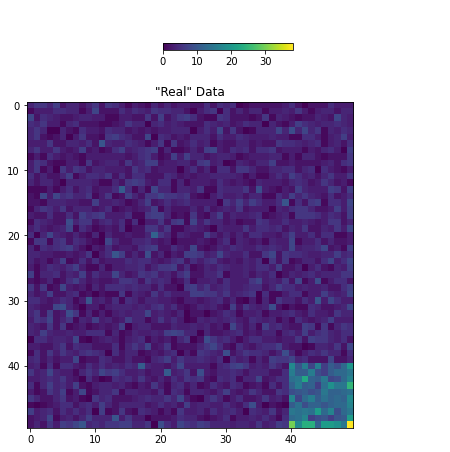

In [164]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_title('"Real" Data')
plt.imshow(synth.synthetic_histograms[0][1])
ax.set_aspect('equal')
cax = fig.add_axes([0.1, 1.0, 1., 0.1])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal')
plt.show()

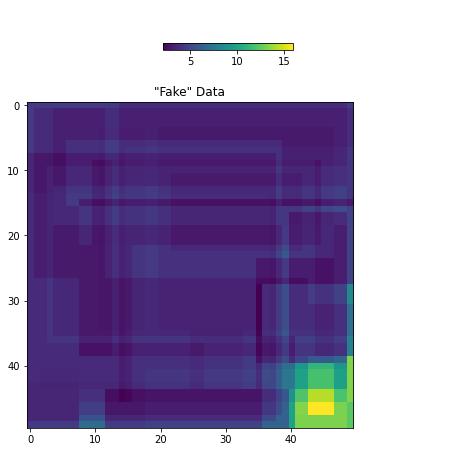

In [165]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.set_title('"Fake" Data')
plt.imshow(synth.synthetic_histograms[0][0])
cax = fig.add_axes([0.1, 1.0, 1., 0.1])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal')
plt.show()